# 1. Introduction to Data Integration and APIs in Data Engineering


## 1.1 What are APIs?


<font size = "4">APIs, or Application Programming Interfaces, are a set of rules and protocols that allow one piece of software or program to interact with another. They define the methods and data formats that developers can use to interact with the software component, be it operating systems, libraries, or different services.</font>


## 1.2 What is REST?

<font size = "4">REST, which stands for Representational State Transfer, is an architectural style for designing networked applications. REST uses a stateless, client-server communication model, which treats API endpoints as resources that can be created, retrieved, updated, or deleted using standard HTTP methods.</font>


## 1.3 Importance in Data Engineering

<font size = "4">Data integration is central to data engineering, particularly in the contemporary business environment where the volume of data is burgeoning. It facilitates a unified view of data from various sources, encouraging collaboration and enhancing data accuracy, which is vital for strategic decision-making within organizations. Moreover, modern cloud data platforms have a significant role in data management, aiding in the maintenance of data quality and trustworthiness <a href="https://www.techtarget.com/searchdatamanagement/feature/Effective-integration-key-to-creating-trusted-data">Source1</a>, <a href="https://dev.to/k_ndrick/data-engineering-for-beginners-a-step-by-step-guide-3d1f">Source2</a></font>


<font size = "4">In this example below, we will demonstrate how to fetch data from a single API endpoint and display it, which is a basic yet fundamental aspect of data integration in data engineering.</font><br><br>

In [57]:
import requests
import pandas as pd

# Define the API endpoint and parameters
api_endpoint = "https://api.openaq.org/v2/latest"
params = {
    "city": "London",
    "limit": 100
}
headers = {
    "X-API-Key": "OpenAQ API Key"
}

# Make a GET request to the API
response = requests.get(api_endpoint, params=params, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    
    # Load data into a pandas DataFrame
    df = pd.DataFrame(data['results'])
    
    # Extract measurements as a separate DataFrame
    measurements_df = pd.DataFrame([x['measurements'][0] for x in data['results']])
    
    # Perform data cleaning steps (like handling missing values)
    measurements_df.dropna(inplace=True)
    
    # Perform basic data analysis (like calculating the average value of measurements)
    average_measurement = measurements_df['value'].mean()
    print(f"The average measurement value is: {average_measurement}")

else:
    print(f"Failed to retrieve data. HTTP Status code: {response.status_code}")

The average measurement value is: 44.0136


<br><font size="4">The above code can be further modified to explore the measurements_df as shown below</font><br><br>

In [58]:
measurements_df

,parameter,value,lastUpdated,unit
0,pm10,7.00,2024-02-10T12:04:13+00:00,µg/m³
1,pm10,15.00,2024-02-10T12:04:08+00:00,µg/m³
2,pm10,10.00,2024-02-10T12:04:08+00:00,µg/m³
3,pm10,14.00,2024-02-10T12:04:08+00:00,µg/m³
4,pm10,4.00,2024-02-10T12:04:07+00:00,µg/m³
...,...,...,...,...
95,humidity,64.00,2024-02-09T19:13:46+00:00,%
96,um003,0.03,2024-02-09T19:13:46+00:00,particles/cm³
97,pm1,1.30,2024-02-09T19:13:46+00:00,µg/m³
98,humidity,59.00,2024-02-09T19:13:46+00:00,%


<br><font size="4">Here is another example to extract data from National Parks API to query their Parks request url</font><br><br>

In [7]:
import requests
import json
import pandas as pd

def fetch_data_from_api(api_url):
    """
    This function takes an API URL as input, sends a request to the API,
    and returns the response data if the request is successful.
    """
    response = requests.get(api_url)
    
    if response.status_code == 200:
        return response.json()
    else:
        return f"Failed to retrieve data. HTTP Status code: {response.status_code}"

# Separate API key as a variable
api_key = "NPS API KEY"

# API endpoint to fetch data, including the API key as a query parameter
api_url = f'https://developer.nps.gov/api/v1/parks?limit=1&api_key={api_key}'

# Fetch data from the API
data = fetch_data_from_api(api_url)

<br><font size = "4">Here we will pretty print the json to show the nested natured of the returned data</font><br><br>

In [8]:
# Pretty print the JSON data
print("Pretty Printed JSON Data:")
print(json.dumps(data, indent=4))

Pretty Printed JSON Data:
{
    "total": "471",
    "limit": "1",
    "start": "0",
    "data": [
        {
            "id": "77E0D7F0-1942-494A-ACE2-9004D2BDC59E",
            "url": "https://www.nps.gov/abli/index.htm",
            "fullName": "Abraham Lincoln Birthplace National Historical Park",
            "parkCode": "abli",
            "description": "For over a century people from around the world have come to rural Central Kentucky to honor the humble beginnings of our 16th president, Abraham Lincoln. His early life on Kentucky's frontier shaped his character and prepared him to lead the nation through Civil War. Visit our country's first memorial to Lincoln, built with donations from young and old, and the site of his childhood home.",
            "latitude": "37.5858662",
            "longitude": "-85.67330523",
            "latLong": "lat:37.5858662, long:-85.67330523",
            "activities": [
                {
                    "id": "13A57703-BB1A-41A2-94B8-53B692E

<br><font size = "4">As you can see that the nested json has a multi-level parent-child structure and hence simple json_normalize might not be useful in analyzing the data. Hence, we will denormalize the nested elements dynamically and adding the child elements parent key name to the column to expand the dataframe.</font><br><br>

<font size = "4">For example <code>activities</code> has nested element with keys <code>id</code>, and <code>name</code> which we will flatten to <code>activities_id, activities_name</code> and recusrively for other columns with nested key value pairs as well.</font><br><br>

In [24]:
# Extract the 'data' field which contains the information we want to normalize
data_to_normalize = data.get('data', [{}])[0]

# Convert the nested JSON structures within each column to a flat structure
main_df = pd.json_normalize(data_to_normalize)

def extract_nested_data(df):
    """
    This recursive function takes a DataFrame as input, checks each column for nested structures,
    and denormalizes nested elements if any are found. It continues to denormalize
    until all nested structures are fully denormalized.
    """
    while True:
        nested_cols = [col for col in df.columns if isinstance(df[col].iloc[0], list)]
        
        if not nested_cols:
            break
        
        for col in nested_cols:
            expanded_col_df = pd.json_normalize(df[col].explode().apply(lambda x: x if isinstance(x, dict) else {}))
            expanded_col_df.index = df.index.repeat(df[col].apply(len))
            prefix = f'{col}_'
            expanded_col_df = expanded_col_df.add_prefix(prefix)
            df = df.drop(columns=[col])
            df = df.join(expanded_col_df).reset_index(drop=True)
    
    return df

# Apply the function to denormalize all nested elements in the DataFrame
flattened_df = extract_nested_data(main_df)
flattened_df

,id,url,fullName,parkCode,description,latitude,longitude,latLong,states,directionsInfo,directionsUrl,weatherInfo,name,designation,relevanceScore,activities_id,activities_name,topics_id,topics_name,operatingHours_description,operatingHours_name,operatingHours_standardHours.wednesday,operatingHours_standardHours.monday,operatingHours_standardHours.thursday,operatingHours_standardHours.sunday,operatingHours_standardHours.tuesday,operatingHours_standardHours.friday,operatingHours_standardHours.saturday,addresses_postalCode,addresses_city,addresses_stateCode,addresses_countryCode,addresses_provinceTerritoryCode,addresses_line1,addresses_type,addresses_line3,addresses_line2,images_credit,images_title,images_altText,images_caption,images_url,contacts.phoneNumbers_phoneNumber,contacts.phoneNumbers_description,contacts.phoneNumbers_extension,contacts.phoneNumbers_type,contacts.emailAddresses_description,contacts.emailAddresses_emailAddress,operatingHours_exceptions_startDate,operatingHours_exceptions_name,operatingHours_exceptions_endDate,operatingHours_exceptions_exceptionHours.wednesday,operatingHours_exceptions_exceptionHours.monday,operatingHours_exceptions_exceptionHours.thursday,operatingHours_exceptions_exceptionHours.sunday,operatingHours_exceptions_exceptionHours.tuesday,operatingHours_exceptions_exceptionHours.friday,operatingHours_exceptions_exceptionHours.saturday
0,77E0D7F0-1942-494A-ACE2-9004D2BDC59E,https://www.nps.gov/abli/index.htm,Abraham Lincoln Birthplace National Historical Park,abli,"For over a century people from around the world have come to rural Central Kentucky to honor the humble beginnings of our 16th president, Abraham Lincoln. His early life on Kentucky's frontier shaped his character and prepared him to lead the nation through Civil War. Visit our country's first memorial to Lincoln, built with donations from young and old, and the site of his childhood home.",37.5858662,-85.67330523,"lat:37.5858662, long:-85.67330523",KY,The Birthplace Unit of the park is located approximately 2 miles south of the town of Hodgenville on U.S. Highway 31E South. The Boyhood Home Unit at Knob Creek is located approximately 10 miles northeast of the Birthplace Unit of the park.,http://www.nps.gov/abli/planyourvisit/directions.htm,"There are four distinct seasons in Central Kentucky. However, temperature and weather conditions can vary widely within those seasons. Spring and Fall are generally pleasant with frequent rain showers. Summer is usually hot and humid. Winter is moderately cold with mixed precipitation.",Abraham Lincoln Birthplace,National Historical Park,1.0,13A57703-BB1A-41A2-94B8-53B692EB7238,Astronomy,D10852A3-443C-4743-A5FA-6DD6D2A054B3,Birthplace,Memorial Building:\nopen 9:00 am - 4:30 pm eastern time.\n\nBirthplace Unit Visitor Center and Grounds: \nopen 9:00 am - 5:00 pm eastern time.,Birthplace Unit,9:00AM - 5:00PM,9:00AM - 5:00PM,9:00AM - 5:00PM,9:00AM - 5:00PM,9:00AM - 5:00PM,9:00AM - 5:00PM,9:00AM - 5:00PM,42748,Hodgenville,KY,US,,2995 Lincoln Farm Road,Physical,,,NPS Photo,The Memorial Building with fall colors,The Memorial Building surrounded by fall colors,"Over 200,000 people a year come to walk up the steps of the Memorial Building to visit the site where Abraham Lincoln was born",https://www.nps.gov/common/uploads/structured_data/3C861078-1DD8-B71B-0B774A242EF6A706.jpg,2703583137,,,Voice,,ABLI_Administration@nps.gov,2024-11-28,Park is Closed,2024-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,77E0D7F0-1942-494A-ACE2-9004D2BDC59E,https://www.nps.gov/abli/index.htm,Abraham Lincoln Birthplace National Historical Park,abli,"For over a century people from around the world have come to rural Central Kentucky to honor the humble beginnings of our 16th president, Abraham Lincoln. His early life on Kentucky's frontier shaped his character and prepared him to lead the nation through Civil War. Visit our country's first memorial to Lincoln, built with donations from young and old, and the site of his childhood home.",3

<br><font size="4">Below is a set of pandas display options I set for exploring all the columns without truncating them in the display</font><br><br>

In [68]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Prevent truncation of column width
pd.set_option('display.width', None)

<br><br><font size="4"><b>For our next exercise we will look into fetching crime data for a month from multiple API sources</b></font><br><br>

In [113]:
import pandas as pd

# Date range for filtering the data (Jan 1, 2024 to Jan 31, 2024)
start_date_filter = "2024-01-01T00:00:00.000"
end_date_filter = "2024-01-31T23:59:59.000"

# URLs to the open data sets for crime in various cities with date range filters applied
la_crime_data_url = f"https://data.lacity.org/resource/2nrs-mtv8.csv?$where=date_occ%20>=%20'{start_date_filter}'%20AND%20date_occ%20<=%20'{end_date_filter}'&$limit=100000"
sf_crime_data_url = f"https://data.sfgov.org/resource/wg3w-h783.csv?$where=incident_date%20between%20'{start_date_filter}'%20and%20'{end_date_filter}'&$limit=100000"
chicago_crime_data_url = f"https://data.cityofchicago.org/resource/ijzp-q8t2.csv?$where=date%20>=%20'{start_date_filter}'%20AND%20date%20<=%20'{end_date_filter}'&$limit=100000"
seattle_crime_data_url = f"https://data.seattle.gov/resource/tazs-3rd5.csv?$where=offense_start_datetime%20>=%20'{start_date_filter}'%20AND%20offense_start_datetime%20<=%20'{end_date_filter}'&$limit=100000"

# Load the data into pandas dataframes
la_crime_df = pd.read_csv(la_crime_data_url)
sf_crime_df = pd.read_csv(sf_crime_data_url)
chicago_crime_df = pd.read_csv(chicago_crime_data_url)
seattle_crime_df = pd.read_csv(seattle_crime_data_url)

<br><br><font size="4">Upon exploring the dataframes from each city you will realize that they are diverse and incompatible from headers perspective but there are underlying common data elements</font>

<font size="4">Hence the next step is to transform these dataframes to be merge compatible as shown below</font><br><br>

In [ ]:
# Step 1: Data Cleansing - Keeping only necessary columns and adding city column
la_crime_df = la_crime_df[['date_occ', 'crm_cd_desc', 'lat', 'lon']]
la_crime_df['City'] = 'Los Angeles'

sf_crime_df = sf_crime_df[['incident_date', 'incident_category', 'latitude', 'longitude']]
sf_crime_df['City'] = 'San Francisco'

chicago_crime_df = chicago_crime_df[['date', 'primary_type', 'latitude', 'longitude']]
chicago_crime_df['City'] = 'Chicago'

seattle_crime_df = seattle_crime_df[['offense_start_datetime', 'offense', 'latitude', 'longitude']]
seattle_crime_df['City'] = 'Seattle'

# Step 2: Standardizing Column Names
la_crime_df.columns = ['Crime Date', 'Crime Description', 'Latitude', 'Longitude', 'City']
sf_crime_df.columns = ['Crime Date', 'Crime Description', 'Latitude', 'Longitude', 'City']
chicago_crime_df.columns = ['Crime Date', 'Crime Description', 'Latitude', 'Longitude', 'City']
seattle_crime_df.columns = ['Crime Date', 'Crime Description', 'Latitude', 'Longitude', 'City']

# Step 3: Combining Data
combined_data = pd.concat([la_crime_df, sf_crime_df, chicago_crime_df, seattle_crime_df], ignore_index=True)

# Step 4: Data Type Conversion
combined_data['Crime Date'] = pd.to_datetime(combined_data['Crime Date']).dt.date

<br><br><font size="4">Next for these cities lets look at getting weather data for the same time period from weatherapi.com. It would be helpful to look into the api <a href='https://www.weatherapi.com/docs/'>documentation</a> to explore other fields you might be interested to extract from the weather api<br><br> 

In [ ]:
from datetime import datetime, timedelta
import requests
import pandas as pd

weather_api_key = "Your WeatherAPI API key"

# List of city names
cities = ["Los Angeles", "San Francisco", "Chicago", "Seattle"]

# Initialize an empty list to store weather data
weather_data_list = []

# Define the start and end date
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 1, 31)
delta = timedelta(days=1)

# Loop through each city and date to fetch the weather data
for city in cities:
    current_date = start_date
    while current_date <= end_date:
        response = requests.get(f"http://api.weatherapi.com/v1/history.json?key={weather_api_key}&q={city}&dt={current_date.strftime('%Y-%m-%d')}")
        response.raise_for_status()
        data = response.json()
        day_data = data['forecast']['forecastday'][0]['day']
        location_data = data['location']
        weather_data_list.append({
            'City': city,
            'Date': current_date,
            'Weather Description': day_data['condition']['text'],
            'Max Temp (C)': day_data['maxtemp_c'],
            'Min Temp (C)': day_data['mintemp_c'],
            'Precipitation (mm)': day_data['totalprecip_mm']
        })
        current_date += delta

# Create a data frame from the weather data list
weather_data_df = pd.DataFrame(weather_data_list)

<br><br><font size="4">Next step is to merge the crime data with the weather data on City and time period as the key</font>

<font size="2">Note: Some weather APIs return more extensive data by lat and long values but for the sake of simplicity here we are relying on merging only on cities</font>

In [ ]:
# Convert 'Date' in weather_data_df to date format
weather_data_df['Date'] = pd.to_datetime(weather_data_df['Date']).dt.date

# Merge the data frames on 'City' and 'Date'
final_data = pd.merge(combined_data, weather_data_df, left_on=['City', 'Crime Date'], right_on=['City', 'Date'], how='inner')



### Next we will observe some trends, patterns and correlation between the weather and crime stats
<br>

#### Monthly Crime Rate: We will group the data by date and count the number of incidents per day, then plot this as a time series.

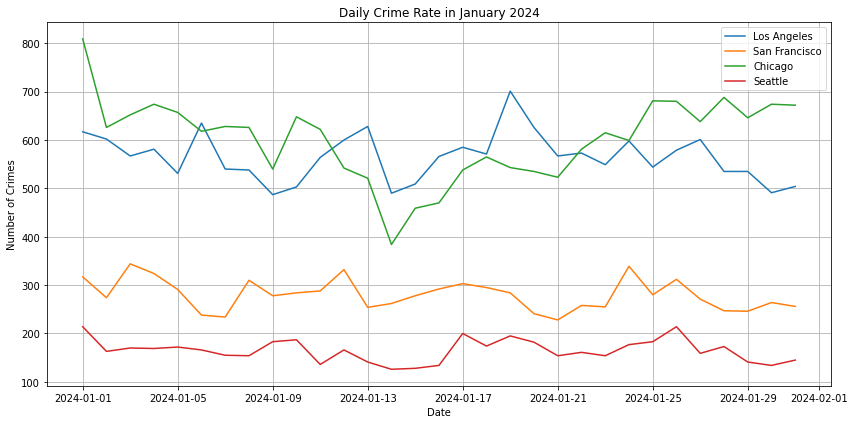

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd

# Assuming final_data is the name of your dataframe
final_data['Crime Date'] = pd.to_datetime(final_data['Crime Date'])

# 1. Monthly Crime Rate
plt.figure(figsize=(12, 6))
for city in final_data['City'].unique():
    city_data = final_data[final_data['City'] == city]
    daily_crime_count = city_data.groupby(city_data['Crime Date'].dt.date).size()
    daily_crime_count.plot(kind='line', label=city)
plt.title('Daily Crime Rate in January 2024')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('daily_crime_rate_jan_2024.png')
plt.show()

#### Crime Type Distribution: We will group the data by the type of crime and count the number of incidents for each type, then plot this as a bar chart.

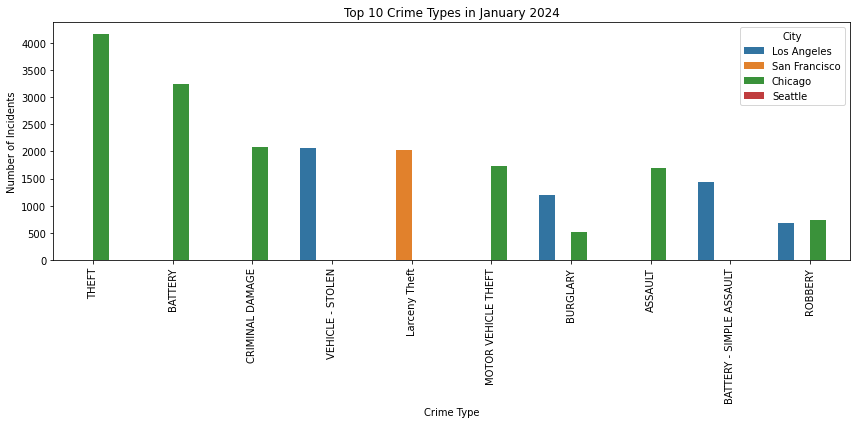

In [118]:
# 2. Crime Type Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='Crime Description', hue='City', data=final_data, order=final_data['Crime Description'].value_counts().iloc[:10].index)
plt.title('Top 10 Crime Types in January 2024')
plt.xlabel('Crime Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('crime_type_distribution_jan_2024.png')
plt.show()

#### Weather Impact on Crime Rate: We will group the data by weather description and count the number of incidents for each weather type, then plot this as a bar chart.

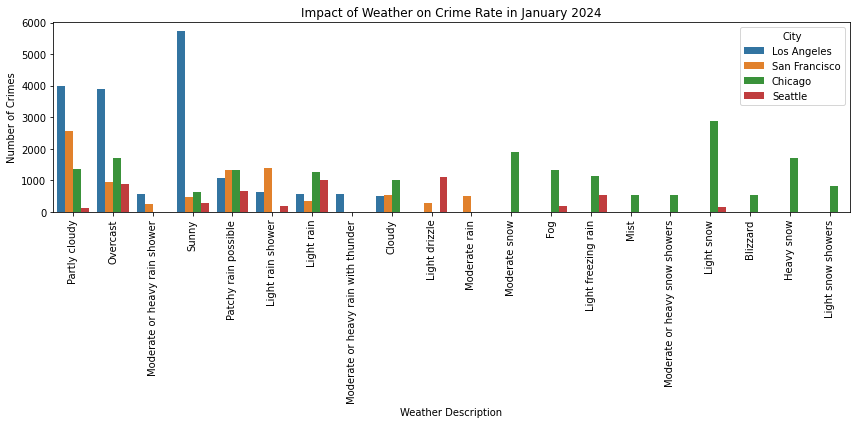

In [119]:
# 3. Weather Impact on Crime Rate
plt.figure(figsize=(12, 6))
sns.countplot(x='Weather Description', hue='City', data=final_data)
plt.title('Impact of Weather on Crime Rate in January 2024')
plt.xlabel('Weather Description')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('weather_impact_on_crime_jan_2024.png')
plt.show()

#### Temperature Impact on Crime Rate: We will create a scatter plot with temperature (we can use max, min, or an average of both) on one axis and the crime rate per day on the other.

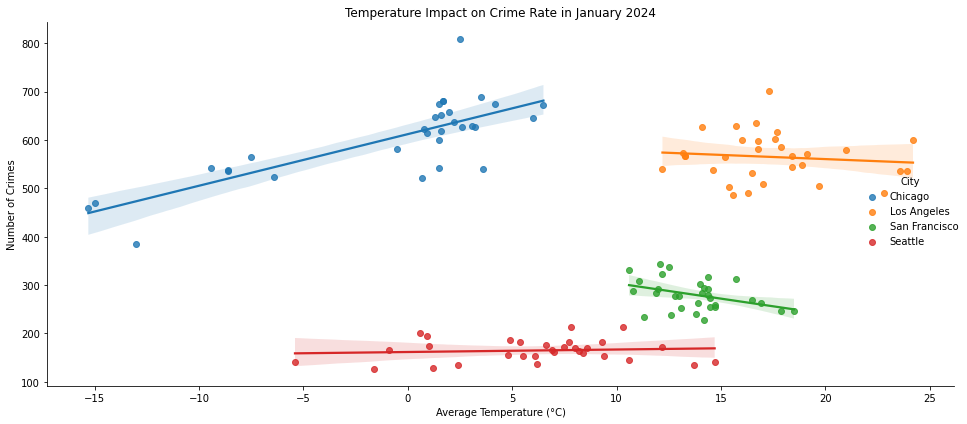

In [129]:
crime_counts_per_day = final_data.groupby(['Crime Date', 'City']).agg(
    crime_count=pd.NamedAgg(column='Crime Description', aggfunc='count'),
    avg_temp=pd.NamedAgg(column='Max Temp (C)', aggfunc='mean')  # Assuming 'Max Temp (C)' column contains average temperatures
).reset_index()

sns.lmplot(x='avg_temp', y='crime_count', hue='City', data=crime_counts_per_day, aspect=2, height=6)
plt.title('Temperature Impact on Crime Rate in January 2024')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Number of Crimes')
plt.tight_layout()
plt.savefig('temperature_impact_on_crime_jan_2024.png')
plt.show()

#### City-wise Crime Distribution: We will group the data by city and count the number of incidents in each, then plot this as a bar chart.

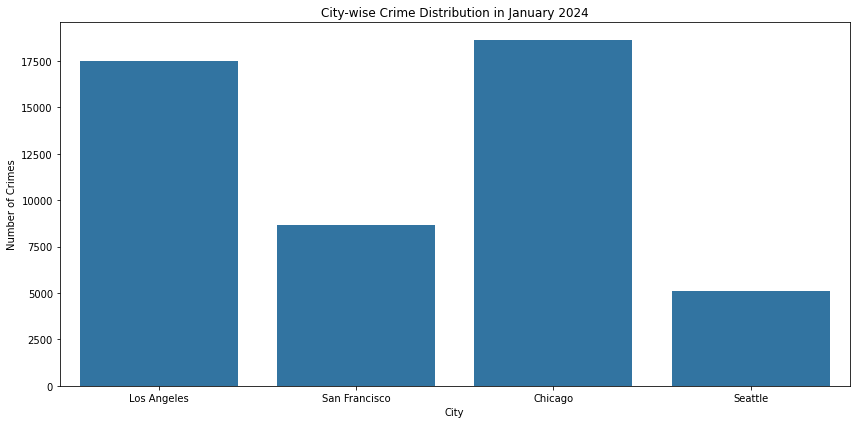

In [121]:
# 6. City-wise Crime Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='City', data=final_data)
plt.title('City-wise Crime Distribution in January 2024')
plt.xlabel('City')
plt.ylabel('Number of Crimes')
plt.tight_layout()
plt.savefig('city_wise_crime_distribution_jan_2024.png')
plt.show()

#### Crime Heatmap: We will use the latitude and longitude columns to create a heatmap showing the density of crime incidents.

In [124]:
import folium
from folium.plugins import HeatMap

# Create a map centered at an average location
map_center = [combined_data['Latitude'].mean(), combined_data['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=5)

# Prepare data for the heatmap
heat_data = [[row['Latitude'], row['Longitude']] for index, row in combined_data.dropna(subset=['Latitude', 'Longitude']).iterrows() if row['Latitude'] != 0 and row['Longitude'] != 0]

# Add the heatmap to the map
HeatMap(heat_data).add_to(m)

# Save the map to an HTML file
m.save('crime_heatmap.html')

# Display the map
m

<br><br><font size = "4">Now that we have explored and practised a few examples on querying API endpoints, and processing the responses. Let's delve deeper into REST APIs</font>


# 2. Overview of REST APIs


## 2.1 Principles


<font size = "4"><ul>
    <li><b>Stateless:</b> Each request from a client to a server must contain all the information needed to understand and process the request.</li><br>
    <li><b>Client-server architecture:</b> Separates the user interface from the data storage, improving the portability of the user interface across multiple platforms.</li><br>
    <li><b>Uniform interface:</b> Simplifies and decouples the architecture, allowing each part to evolve independently.</li></ul></font>
    

## 2.2 Features of REST APIs


<font size = "4"><b>2.2.1 Scalability: </b>Scalability is one of the significant advantages of REST APIs. Due to its stateless nature and the usage of standard HTTP methods, REST APIs can handle requests from a large number of clients. This feature ensures that as the number of users grows, the API can scale to meet the increased demand.</font> 



<font size = "4">To illustrate this, imagine a web application that uses a REST API to fetch user data. As the number of users grows, the server's load increases. The API can handle this growth by efficiently distributing the requests across multiple servers.</font>


<font size = "4">Here's a Python script that simulates multiple clients making GET requests to a REST API concurrently using the <code>concurrent.futures.ThreadPoolExecutor:</code></font>

In [130]:
from concurrent.futures import ThreadPoolExecutor
import requests

def fetch_data(url):
    """
    This function sends a GET request to the specified URL and returns the JSON response.
    """
    response = requests.get(url)
    return response.json()

# List of URLs to fetch data from (simulating multiple clients)
urls = ["https://jsonplaceholder.typicode.com/posts/1",
        "https://jsonplaceholder.typicode.com/posts/2",
        "https://jsonplaceholder.typicode.com/posts/3"]

# Creating a thread pool and making GET requests concurrently
with ThreadPoolExecutor() as executor:
    results = executor.map(fetch_data, urls)
    
    for result in results:
        print(result)

{'userId': 1, 'id': 1, 'title': 'sunt aut facere repellat provident occaecati excepturi optio reprehenderit', 'body': 'quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto'}
{'userId': 1, 'id': 2, 'title': 'qui est esse', 'body': 'est rerum tempore vitae\nsequi sint nihil reprehenderit dolor beatae ea dolores neque\nfugiat blanditiis voluptate porro vel nihil molestiae ut reiciendis\nqui aperiam non debitis possimus qui neque nisi nulla'}
{'userId': 1, 'id': 3, 'title': 'ea molestias quasi exercitationem repellat qui ipsa sit aut', 'body': 'et iusto sed quo iure\nvoluptatem occaecati omnis eligendi aut ad\nvoluptatem doloribus vel accusantium quis pariatur\nmolestiae porro eius odio et labore et velit aut'}


<font size = "3"><b>NOTE:</b> In this script, the ThreadPoolExecutor class is used to create a pool of threads, each making a separate GET request to the API concurrently. ThreadPoolExecutor is a high-level interface for asynchronously executing callables. It manages a pool of worker threads that can execute tasks in parallel, thus demonstrating the scalability of REST APIs as it can efficiently handle multiple requests at the same time, simulating a scenario where the API is handling requests from a growing number of users.</font>

<br>
<font size="4"><b>2.2.2 Performance:</b> Performance in REST APIs refers to the speed and efficiency with which an API can handle and respond to requests. The performance of an API can be optimized in various ways, including efficient data handling and processing, implementing caching mechanisms, and optimizing database queries.</font>


<font size="4">To exemplify this, we can create a Python script that utilizes caching to improve the performance of API requests. Caching involves storing copies of frequently accessed data in memory, so subsequent requests for the same data can be served faster, without needing to retrieve the data from the original source each time.</font>

In [ ]:
import sys
!{sys.executable} -m pip install requests_cache

In [133]:
import requests_cache
import requests

# Setup cache that expires after 300 seconds (5 minutes)
requests_cache.install_cache('api_cache', expire_after=300)

def fetch_data(url):
    """
    This function sends a GET request to the specified URL and returns the JSON response.
    It utilizes caching to improve the performance of repeated requests to the same URL.
    """
    response = requests.get(url)
    if response.from_cache:
        print("Returning data from cache")
    else:
        print("Fetching data from API")
    return response.json()

# URL to fetch data from
url = "https://jsonplaceholder.typicode.com/posts/1"

# Making GET requests to the API
print(fetch_data(url))  # This will fetch data from the API
print(fetch_data(url))  # This will return data from the cache, improving performance

Fetching data from API
{'userId': 1, 'id': 1, 'title': 'sunt aut facere repellat provident occaecati excepturi optio reprehenderit', 'body': 'quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto'}
Returning data from cache
{'userId': 1, 'id': 1, 'title': 'sunt aut facere repellat provident occaecati excepturi optio reprehenderit', 'body': 'quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto'}


<font size="3"><b>Note: </b>In this script, the requests_cache library is used to cache the responses from the API. When the fetch_data function is called multiple times with the same URL, the response from the first request is cached, so subsequent requests are served from the cache, speeding up the response time and reducing the load on the API server.</font>

<font size="4"><b>2.2.3 Modifiability: </b>Modifiability in REST APIs refers to the ease with which the API can be altered or extended over time. The REST architectural style encourages the creation of APIs with clear, predictable behavior and a structured format, which allows for easier modifications and extensions in the future.</font>


<font size="4">To illustrate this, we can consider a Python script that interacts with an API which follows REST principles. In such an API, resources are represented using standard conventions, making it easier to extend the functionality of the script to include additional features or endpoints as the API evolves.</font>

In [137]:
import requests
import json

class APIClient:
    """
    A Python class that acts as a client for a REST API. 
    Demonstrates the modifiability feature of REST APIs by providing structured 
    methods to interact with different API endpoints.
    """
    BASE_URL = "https://jsonplaceholder.typicode.com"
    
    def get_post(self, post_id):
        """Fetches and returns the details of a single post."""
        response = requests.get(f"{self.BASE_URL}/posts/{post_id}")
        return json.dumps(response.json(), indent=4)
    
    def get_comments(self, post_id):
        """Fetches and returns the comments of a single post."""
        response = requests.get(f"{self.BASE_URL}/posts/{post_id}/comments")
        return json.dumps(response.json(), indent=4)
    
    def create_post(self, data):
        """Creates a new post with the given data."""
        response = requests.post(f"{self.BASE_URL}/posts", json=data)
        return json.dumps(response.json(), indent=4)

# Example usage:
client = APIClient()
print(client.get_post(1))
print(client.get_comments(1))

# Creating a new post
new_post_data = {
    "title": "New Post",
    "body": "This is the content of the new post",
    "userId": 1
}
print(client.create_post(new_post_data))

{
    "userId": 1,
    "id": 1,
    "title": "sunt aut facere repellat provident occaecati excepturi optio reprehenderit",
    "body": "quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto"
}
[
    {
        "postId": 1,
        "id": 1,
        "name": "id labore ex et quam laborum",
        "email": "Eliseo@gardner.biz",
        "body": "laudantium enim quasi est quidem magnam voluptate ipsam eos\ntempora quo necessitatibus\ndolor quam autem quasi\nreiciendis et nam sapiente accusantium"
    },
    {
        "postId": 1,
        "id": 2,
        "name": "quo vero reiciendis velit similique earum",
        "email": "Jayne_Kuhic@sydney.com",
        "body": "est natus enim nihil est dolore omnis voluptatem numquam\net omnis occaecati quod ullam at\nvoluptatem error expedita pariatur\nnihil sint nostrum voluptatem reiciendis et"
    },
    {
        "postId": 1,
        "id": 3,


<font size="3"><b>Note: </b>In this script, the APIClient class is structured to easily interact with various endpoints of the API. If the API evolves to include new endpoints or functionalities, the class can be easily extended to incorporate these changes, showcasing the modifiability feature of REST APIs.</font>

## 2.3 Advantages and Use Cases of REST APIs

<font size="4">In this section, we will explore the various benefits of using REST APIs and the scenarios where they can be particularly useful.</font>


<font size="4"><b>2.3.1 Simplicity of Interfaces</b></font>

<font size="4">REST APIs often have simple, user-friendly interfaces. The use of standard HTTP methods (GET, POST, PUT, DELETE) and stateless operations make the development, integration, and scaling of applications simpler and more intuitive.</font>

<font size="4">To demonstrate this, we can create a Python script that interacts with a REST API using simple HTTP methods to perform CRUD (Create, Read, Update, Delete) operations. The script will showcase the simplicity and intuitiveness of REST API interfaces.</font>

In [138]:
import requests
import json

class SimpleAPIClient:
    """
    A Python class demonstrating the simplicity of REST API interfaces 
    through CRUD operations using standard HTTP methods.
    """
    BASE_URL = "https://jsonplaceholder.typicode.com"
    
    def create_post(self, data):
        """Creates a new post using the POST method."""
        response = requests.post(f"{self.BASE_URL}/posts", json=data)
        return json.dumps(response.json(), indent=4)
    
    def read_post(self, post_id):
        """Reads a post using the GET method."""
        response = requests.get(f"{self.BASE_URL}/posts/{post_id}")
        return json.dumps(response.json(), indent=4)
    
    def update_post(self, post_id, data):
        """Updates a post using the PUT method."""
        response = requests.put(f"{self.BASE_URL}/posts/{post_id}", json=data)
        return json.dumps(response.json(), indent=4)
    
    def delete_post(self, post_id):
        """Deletes a post using the DELETE method."""
        response = requests.delete(f"{self.BASE_URL}/posts/{post_id}")
        return response.status_code

# Example usage:
client = SimpleAPIClient()

# Creating a new post
new_post_data = {
    "title": "New Post",
    "body": "This is the content of the new post",
    "userId": 1
}
print(client.create_post(new_post_data))

# Reading a post
print(client.read_post(1))

# Updating a post
update_data = {
    "title": "Updated Post",
    "body": "This is the updated content of the post",
    "userId": 1
}
print(client.update_post(1, update_data))

# Deleting a post
print(client.delete_post(1))

{
    "title": "New Post",
    "body": "This is the content of the new post",
    "userId": 1,
    "id": 101
}
{
    "userId": 1,
    "id": 1,
    "title": "sunt aut facere repellat provident occaecati excepturi optio reprehenderit",
    "body": "quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto"
}
{
    "title": "Updated Post",
    "body": "This is the updated content of the post",
    "userId": 1,
    "id": 1
}
200


<font size="3"><b>Note: </b>In this script, we have a SimpleAPIClient class that demonstrates the simplicity of REST API interfaces through straightforward CRUD operations using standard HTTP methods. Each method in the class corresponds to a different HTTP method, showcasing the intuitive and user-friendly nature of REST APIs.</font>

<br>
<font size="4"><b>2.3.2 Scalability of Components</b></font>

<font size="4">One of the notable advantages of REST APIs is the scalability of its components. The stateless nature of REST allows each request to be independent, making it easier to scale the application horizontally by adding more servers. Moreover, the separation of client and server allows developers to scale and deploy them independently.</font>

<font size="4">To illustrate this, let's consider an example where a Python script communicates with a REST API to fetch data from multiple endpoints concurrently, similar to the scalability example in section 2.2.1, but with a focus on the independence and scalability of components.</font>

In [141]:
from concurrent.futures import ThreadPoolExecutor
import requests
import json
import requests_cache

# Uninstall the previously installed cache
requests_cache.uninstall_cache()

def fetch_data(endpoint):
    """
    This function sends a GET request to the specified endpoint of the REST API 
    and returns the JSON response, demonstrating the scalability of REST API components.
    """
    BASE_URL = "https://jsonplaceholder.typicode.com"
    response = requests.get(f"{BASE_URL}/{endpoint}")
    return json.dumps(response.json(), indent=4)

# List of different API endpoints to fetch data from (showcasing component scalability)
endpoints = ["posts/1", "comments?postId=1", "albums/1/photos"]

# Creating a thread pool and making GET requests concurrently
with ThreadPoolExecutor() as executor:
    results = executor.map(fetch_data, endpoints)
    
    for result in results:
        print(result)

{
    "userId": 1,
    "id": 1,
    "title": "sunt aut facere repellat provident occaecati excepturi optio reprehenderit",
    "body": "quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto"
}
[
    {
        "postId": 1,
        "id": 1,
        "name": "id labore ex et quam laborum",
        "email": "Eliseo@gardner.biz",
        "body": "laudantium enim quasi est quidem magnam voluptate ipsam eos\ntempora quo necessitatibus\ndolor quam autem quasi\nreiciendis et nam sapiente accusantium"
    },
    {
        "postId": 1,
        "id": 2,
        "name": "quo vero reiciendis velit similique earum",
        "email": "Jayne_Kuhic@sydney.com",
        "body": "est natus enim nihil est dolore omnis voluptatem numquam\net omnis occaecati quod ullam at\nvoluptatem error expedita pariatur\nnihil sint nostrum voluptatem reiciendis et"
    },
    {
        "postId": 1,
        "id": 3,


<font size="3"><b>Note: </b>In this script, we use ThreadPoolExecutor again to create a pool of threads that make GET requests to different endpoints of the API concurrently. This demonstrates the scalability of REST API components, as each component (or endpoint in this case) can independently handle requests, and the system can be scaled by adding more components or servers to handle the increased load.</font>

<br>
<font size="4"><b>2.3.3 Modifiability of Components</b></font>

<font size="4">Modifiability in REST APIs refers to the ease with which individual components or endpoints of the API can be altered or extended over time. Due to the stateless nature and the clear separation of concerns in REST architecture, it is easier to update or modify individual components without affecting the overall system.</font>

<font size="4">To illustrate the modifiability of components in REST APIs, let's consider a Python script that interacts with a REST API and includes a method to fetch data from a new endpoint, showcasing the ease of extending the script to include new functionalities as the API evolves.</font>

In [142]:
import requests
import json

class ModifiableAPIClient:
    """
    A Python class that interacts with a REST API and can be easily modified 
    to include new functionalities or endpoints, demonstrating the modifiability 
    of components in REST APIs.
    """
    BASE_URL = "https://jsonplaceholder.typicode.com"
    
    def get_post(self, post_id):
        """Fetches and returns the details of a single post."""
        response = requests.get(f"{self.BASE_URL}/posts/{post_id}")
        return json.dumps(response.json(), indent=4)
    
    def get_comments(self, post_id):
        """Fetches and returns the comments of a single post."""
        response = requests.get(f"{self.BASE_URL}/posts/{post_id}/comments")
        return json.dumps(response.json(), indent=4)
    
    def get_album_photos(self, album_id):
        """New method to fetch and return photos of a specific album."""
        response = requests.get(f"{self.BASE_URL}/albums/{album_id}/photos")
        return json.dumps(response.json(), indent=4)

# Example usage:
client = ModifiableAPIClient()
print(client.get_post(1))
print(client.get_comments(1))
print(client.get_album_photos(1))  # New functionality showcasing modifiability

{
    "userId": 1,
    "id": 1,
    "title": "sunt aut facere repellat provident occaecati excepturi optio reprehenderit",
    "body": "quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto"
}
[
    {
        "postId": 1,
        "id": 1,
        "name": "id labore ex et quam laborum",
        "email": "Eliseo@gardner.biz",
        "body": "laudantium enim quasi est quidem magnam voluptate ipsam eos\ntempora quo necessitatibus\ndolor quam autem quasi\nreiciendis et nam sapiente accusantium"
    },
    {
        "postId": 1,
        "id": 2,
        "name": "quo vero reiciendis velit similique earum",
        "email": "Jayne_Kuhic@sydney.com",
        "body": "est natus enim nihil est dolore omnis voluptatem numquam\net omnis occaecati quod ullam at\nvoluptatem error expedita pariatur\nnihil sint nostrum voluptatem reiciendis et"
    },
    {
        "postId": 1,
        "id": 3,


<font size="3"><b>Note: </b>In this script, we have added a new method get_album_photos to the ModifiableAPIClient class, showcasing the ease of modifying the class to include new functionalities as the API evolves, thus illustrating the modifiability of components in REST APIs.</font>

<br>
<font size="4"><b>2.3.4 Visibility of Communication</b></font>

<font size="4">Visibility in the context of REST APIs refers to the ability to monitor or view the interactions between components easily. This transparency in communication makes it easier to test, monitor, and diagnose the API, enhancing the maintainability and reliability of the system.</font>

<font size="4">To illustrate this, we can consider a Python script that logs the details of the API requests and responses, showcasing the visibility of communication in REST APIs. Through logging, developers can keep track of the requests made to the API and the responses received, making it easier to identify and troubleshoot issues.</font>

In [143]:
import requests
import json
import logging

# Setting up logging
logging.basicConfig(level=logging.INFO)

class VisibleCommunicationClient:
    """
    A Python class that interacts with a REST API and logs the details 
    of the API requests and responses, demonstrating the visibility 
    of communication in REST APIs.
    """
    BASE_URL = "https://jsonplaceholder.typicode.com"
    
    def get_post(self, post_id):
        """Fetches and returns the details of a single post."""
        url = f"{self.BASE_URL}/posts/{post_id}"
        response = requests.get(url)
        
        # Logging the request and response details
        logging.info(f"GET Request to URL: {url}")
        logging.info(f"Response Status Code: {response.status_code}")
        logging.info(f"Response Data: {json.dumps(response.json(), indent=4)}")
        
        return json.dumps(response.json(), indent=4)
    
# Example usage:
client = VisibleCommunicationClient()
print(client.get_post(1))

INFO:root:GET Request to URL: https://jsonplaceholder.typicode.com/posts/1
INFO:root:Response Status Code: 200
INFO:root:Response Data: {
    "userId": 1,
    "id": 1,
    "title": "sunt aut facere repellat provident occaecati excepturi optio reprehenderit",
    "body": "quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto"
}


{
    "userId": 1,
    "id": 1,
    "title": "sunt aut facere repellat provident occaecati excepturi optio reprehenderit",
    "body": "quia et suscipit\nsuscipit recusandae consequuntur expedita et cum\nreprehenderit molestiae ut ut quas totam\nnostrum rerum est autem sunt rem eveniet architecto"
}


<font size="3"><b>Note: </b>In this script, we have set up logging to log the details of the API requests and responses, showcasing the visibility of communication in REST APIs. The logging.info statements in the get_post method log the URL of the request, the status code of the response, and the data received in the response, demonstrating the transparency in communication between the client and the API.</font>